# CS484 - Programming Assignment 2 

## Parts 1 and 2

Import the necessary libraries for dataset reading, scientific computing and plotting.

In [1]:
import h5py # to import the dataset
import numpy as np # scientific computing library
import matplotlib.pyplot as plt # plotting library

Read the train and test sets, then convert them to numpy arrays.

In [2]:
train = h5py.File('train_catvnoncat.h5', 'r')
train_x = np.array(train['train_set_x'])
train_y = np.array(train['train_set_y'])

In [3]:
test = h5py.File('test_catvnoncat.h5', 'r')
test_x = np.array(test['test_set_x'])
test_y = np.array(test['test_set_y'])

Plot two images belonging to cat and non-cat classes, just for exemplification purposes. 

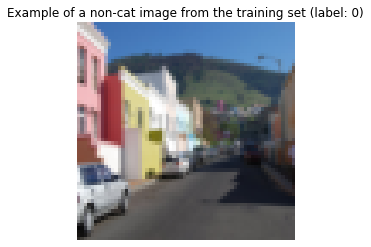

In [4]:
plt.figure()
plt.axis('off')
plt.title('Example of a non-cat image from the training set (label: %d)' % train_y[1])
plt.imshow(train_x[1])
plt.show()

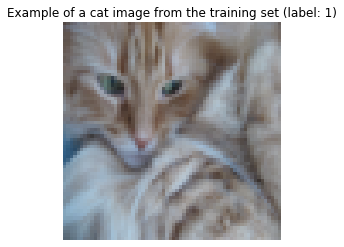

In [5]:
plt.figure()
plt.axis('off')
plt.title('Example of a cat image from the training set (label: %d)' % train_y[2])
plt.imshow(train_x[2])
plt.show()

Flatten each image in the train and test sets into 1-dimensional vectors. This will reduce the image shapes from 64x64x3 to 12288, which implies that an image becomes a vector with 12288 features. This step is needed to feed the input to the perceptron classifier properly. Then typecast the train and test matrices to floats in order to avoid numeric problems. 

In [6]:
train_x_flat = train_x.reshape(train_x.shape[0], -1).T.astype('float64') 
test_x_flat = test_x.reshape(test_x.shape[0], -1).T.astype('float64') 

A perceptron classifier is implemented below as a class. The Perceptron class defines the architecture and the forward/backward computation paths, it implements methods to train itself and report certain classification results. The class must be initialized with instances of train and test samples and labels. 

In [7]:
class Perceptron:
    """
    Represents a Neural Network that consists of a single neuron and is 
    built for binary classification.
    """
    
    def __init__(self, X_train, y_train, X_test, y_test, eta=1e-2, num_iters=1000, seed=0):
        """
        Constructor of the Perceptron class, initializes the model parameters and 
        hyper-parameters, stores the datasets and applies preprocessing if needed.
        Args:
            X_train: the train samples
            y_train: the train labels
            X_test: the test samples
            y_test: the test labels
            eta: learning rate (default is 0.01)
            num_iters: number of gradient descent iterations (default is 1000)
            seed: seed value for random generator (default is 0)
        """
        np.random.seed(seed) # seet the random seed for reproducibility

        # Initialize the training dataset (n: number of features, 
        # m_train: number of training samples, m_test: number of test samples)
        self.X_train = X_train # n x m_train input matrix 
        self.y_train = y_train # 1 x m_train label vector 
        self.X_test = X_test # n x m_test input matrix 
        self.y_test = y_test # 1 x m_test label vector 
        self.n, self.m_train = self.X_train.shape
        self.m_test = len(self.y_test)
        
        # Initialize the model parameters 
        # (random values are divided by 100 for faster convergence)
        self.w = np.random.rand(self.n) / 100 # 1 x n weight vector 
        self.b = np.random.rand() / 100 # scalar bias
        
        # Initialize the hyper-parameters
        self.eta = eta # learning rate
        self.num_iters = num_iters # number of gradient descent iterations
        
        # Store the loss/accuracy histories
        self.losses_train = []
        self.losses_test = []
        self.accuracies = []
        
    def sigmoid(self, z):
        """
        Implementation of the sigmoid function.
        Args:
            z: input to the sigmoid
        Returns:
            The value of the sigmoid function
        """
        z = np.clip(z, -700, 1000) # to avoid numeric overflows
        return 1 / (1 + np.exp(-z))
     
    def log_loss(self, a, y):
        """
        Given the activation vector and true labels, calculates the log loss value.
        Args:
            a: the activation vector
            y: the true labels
        Returns:
            The log loss value
        """
        epsilon = 1e-20 # to avoid NaN values in np.log(0)
        return np.mean(-y * np.log(a + epsilon) - (1 - y) * np.log(1 - a + epsilon))
        
    def train(self, verbose=True):
        """
        The gradient descent algorithm in matrix form, which iteratively updates the
        weights and biases in the direction of the steepest descent in the loss function.
        Args:
            verbose: whether printing is on or off (default is True)
        """
        for i in range(self.num_iters):
            
            # Feed forward
            z = self.w @ self.X_train + self.b
            a = self.sigmoid(z)
            
            # Compute train and test losses, and accuracy
            self.losses_train.append(self.log_loss(a, self.y_train))
            self.losses_test.append(self.log_loss(
                self.sigmoid(self.w @ self.X_test + self.b), self.y_test))
            self.accuracies.append(self.predict())
            
            # Back propagate 
            dz = a - self.y_train
            self.w -= self.eta * (self.X_train @ dz) / self.m_train # update rule for weights
            self.b -= self.eta * np.mean(dz) # update rule for bias
                
            if verbose and i % 50 == 0:
                print('---\nPerformed iteration %d:\ncurrent train loss = %f\ncurrent test loss = %f\n' 
                      % (i + 1, self.losses_train[-1], self.losses_test[-1]))
                
    def train_iterative(self, verbose=True):
        """
        The gradient descent algorithm in iterative form, which iteratively updates the
        weights and biases in the direction of the steepest descent in the loss function.
        Args:
            verbose: whether printing is on or off (default is True)
        """
        for i in range(self.num_iters):
            
            loss_train = 0
            dw = np.zeros(self.n)
            db = 0 
            
            # Compute the gradient
            for j in range(self.m_train):
                z = self.w @ self.X_train[:, j] + self.b
                a = self.sigmoid(z)
                loss_train += self.log_loss(a, self.y_train[j])
                dz = a - self.y_train[j]
                dw += self.X_train[:, j] * dz
                db += dz
                
            loss_train /= self.m_train
            dw /= self.m_train
            db /= self.m_train
            
            # Store train and test losses, and accuracy
            self.losses_train.append(loss_train)
            self.losses_test.append(self.log_loss(
                self.sigmoid(self.w @ self.X_test + self.b), self.y_test))
            self.accuracies.append(self.predict())
            
            self.w -= self.eta * dw
            self.b -= self.eta * db
            
            if verbose and i % 50 == 0:
                print('---\nPerformed iteration %d:\ncurrent train loss = %f\ncurrent test loss = %f\n' 
                      % (i + 1, self.losses_train[-1], self.losses_test[-1]))
                
    def predict(self):
        """
        Feeds the test input forward and applies threshold down operation to
        the resulting activations to obtain the class predictions (outputs). 
        Args:
            verbose: whether printing is on or off (default is True)
        Returns:
            Classification accuracy (proportion of correct predictions)
        """
        output = self.sigmoid(self.w @ self.X_test + self.b)
        output[output >= 0.5] = 1
        output[output < 0.5] = 0
        return np.sum(self.y_test == output) / self.m_test

Initialize a perceptron using the raw datasets, where number of epochs is 50 and learning rate is 0.01.

In [8]:
perceptron_default = Perceptron(train_x_flat, train_y, test_x_flat, test_y, eta=1e-5, num_iters=50)

Train the perceptron. Measure the training time.

In [9]:
%%time
perceptron_default.train(verbose=False)

CPU times: user 911 ms, sys: 7.48 ms, total: 919 ms
Wall time: 116 ms


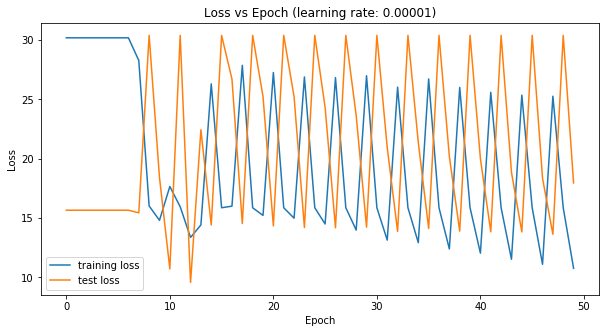

In [10]:
plt.figure(figsize=(10, 5))
plt.title('Loss vs Epoch (learning rate: 0.00001)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(perceptron_default.losses_train)
plt.plot(perceptron_default.losses_test)
plt.legend(['training loss', 'test loss'])
#plt.savefig('part1_plot1.png')
plt.show()

In [11]:
print('Prediction accuracy = %d%%' % (100 * perceptron_default.predict()))

Prediction accuracy = 68%


Train the same perceptron using the iterative form gradient descent. Measure the training time.

In [12]:
perceptron_default = Perceptron(train_x_flat, train_y, test_x_flat, test_y, eta=1e-5, num_iters=50)

In [13]:
%%time
perceptron_default.train_iterative(verbose=False)

CPU times: user 5.39 s, sys: 19 ms, total: 5.4 s
Wall time: 676 ms


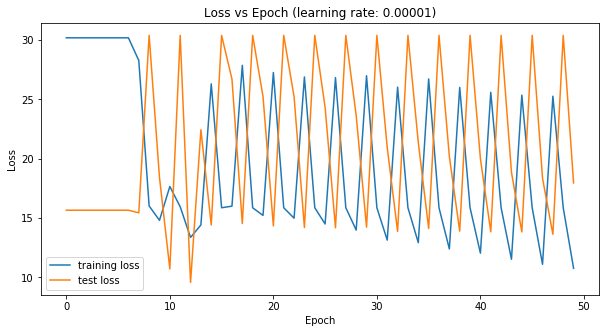

In [14]:
plt.figure(figsize=(10, 5))
plt.title('Loss vs Epoch (learning rate: 0.00001)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(perceptron_default.losses_train)
plt.plot(perceptron_default.losses_test)
plt.legend(['training loss', 'test loss'])
plt.show()

In [15]:
print('Prediction accuracy = %d%%' % (100 * perceptron_default.predict()))

Prediction accuracy = 68%


The iterative gradient descent gives the exact same result, however it runs a lot slower than the matrix form gradient descent.

Augment the dataset by adding basic tranformations of cat-class images. These transformations include rotations and symmetries, some of which are plotted below: 

In [16]:
titles = ['original',
          '90 degrees rotation',
          '180 degrees rotation',
          '270 degrees rotation',
          '(left/right) \n symmetry',
          'symmetry and \n 90 degrees rotation',
          'symmetry and \n 180 degrees rotation',
          'symmetry and \n 270 degrees rotation']

In [17]:
original = train_x[2]
symmetry = np.fliplr(original)

imgs = [original, 
        np.rot90(np.rot90(np.rot90(original))),
        np.rot90(np.rot90(original)),
        np.rot90(original),
        symmetry,
        np.rot90(np.rot90(np.rot90(symmetry))),
        np.rot90(np.rot90(symmetry)),
        np.rot90(symmetry)]

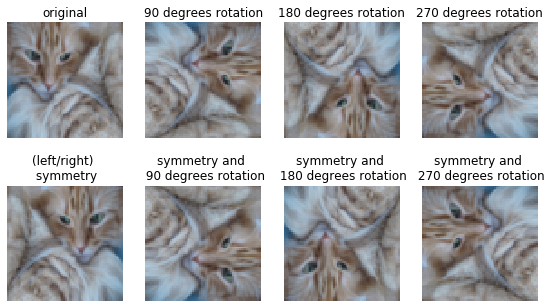

In [18]:
fig = plt.figure(figsize=(9.5, 5.5))
cols = 4
rows = 2
ax = []
for i in range(cols * rows):
    ax.append(fig.add_subplot(rows, cols, i + 1))
    ax[-1].set_title(titles[i])  # set title
    plt.axis('off')
    plt.imshow(imgs[i])
#plt.savefig('part2_dataaug.png')
plt.show()

The method below is expected to boost the classification accuracy by applying five of the above transformations.

In [19]:
def augment_data(data_x, data_y):
    """
    Augments the given dataset by adding basic transformations (rotations and symmetries)
    of cat-class images. 
    Args:
        data_x: The data samples (must be 64x64x3)
        data_y: The data labels
    Returns 
        data_x: Augmented data samples
        data_y: Augmented data labels
    """
    num_samples = len(data_y)
    for i in range(num_samples):
        if data_y[i] == 1:
            original = data_x[i]
            symmetry = np.fliplr(original)
            augment_arr = [np.rot90(np.rot90(np.rot90(original))),
                           np.rot90(np.rot90(original)), 
                           np.rot90(original), 
                           symmetry,
                           #np.rot90(np.rot90(np.rot90(symmetry))), 
                           #np.rot90(np.rot90(symmetry)),
                           #np.rot90(symmetry)
                          ]
            data_x = np.append(data_x, augment_arr, axis=0)
            data_y = np.append(data_y, np.ones(len(augment_arr)))
    return data_x, data_y

In [20]:
train_x_aug, train_y_aug = augment_data(train_x, train_y)
train_x_aug_flat = train_x_aug.reshape(train_x_aug.shape[0], -1).T.astype('float64') 

Feature scaling is a commonly used method to normalize the range of independent features of data, since the range of each feature widely varies in the raw data. The following four methods are different ways of feature scaling:

In [21]:
def standardize(X):
    """
    Applies standardization to a given dataset.
    Args: 
        X: the given dataset
    Returns:
        X: the standardized normalized dataset
    """
    n = X.shape[0]
    mean = np.mean(X, axis=1).reshape(n, 1)
    std = np.std(X, axis=1).reshape(n, 1)
    std[std == 0] = 1e-20 # to avoid divide by zero
    X -= mean
    X /= std
    return X

In [22]:
def mean_normalize(X):
    """
    Applies mean normalization to a given dataset.
    Args: 
        X: the given dataset
    Returns:
        X: the mean normalized dataset
    """
    n = X.shape[0]
    mean = np.mean(X, axis=1).reshape(n, 1)
    min_ = np.min(X, axis=1).reshape(n, 1)
    max_ = np.max(X, axis=1).reshape(n, 1)
    diff = max_ - min_
    diff[diff == 0] = 1e-20 # to avoid divide by zero
    X -= mean
    X /= diff
    return X

In [23]:
def min_max_scale(X):
    """
    Applies min-max scaling to a given dataset.
    Args: 
        X: the given dataset
    Returns:
        X: the min-max scaled dataset
    """
    n = X.shape[0]
    min_ = np.min(X, axis=1).reshape(n, 1)
    max_ = np.max(X, axis=1).reshape(n, 1)
    diff = max_ - min_
    diff[diff == 0] = 1e-20 # to avoid divide by zero
    X -= min_
    X /= diff
    return X

In [24]:
def robust_scale(X):
    """
    Applies robust scaling to a given dataset.
    Args: 
        X: the given dataset
    Returns:
        X: the robust scaled dataset
    """
    n = X.shape[0]
    q1 = np.quantile(X, 0.25, axis=1).reshape(n, 1)
    q3 = np.quantile(X, 0.75, axis=1).reshape(n, 1)
    diff = q3 - q1
    diff[diff == 0] = 1e-20 # to avoid divide by zero
    X -= q1
    X /=  diff
    return X

Mean normalization turns out to be the best feature scaling method for this application in terms of classification accuracy.

In [25]:
train_x_aug_flat_scaled = mean_normalize(train_x_aug_flat) 
test_x_flat_scaled = mean_normalize(test_x_flat)

In [26]:
perceptron = Perceptron(train_x_aug_flat_scaled, train_y_aug,
                        test_x_flat_scaled, test_y)

In [27]:
perceptron.train()

---
Performed iteration 1:
current train loss = 2.712476
current test loss = 1.593482

---
Performed iteration 51:
current train loss = 0.562852
current test loss = 0.532768

---
Performed iteration 101:
current train loss = 0.501927
current test loss = 0.484606

---
Performed iteration 151:
current train loss = 0.457860
current test loss = 0.459368

---
Performed iteration 201:
current train loss = 0.423073
current test loss = 0.444630

---
Performed iteration 251:
current train loss = 0.394527
current test loss = 0.435498

---
Performed iteration 301:
current train loss = 0.370536
current test loss = 0.429678

---
Performed iteration 351:
current train loss = 0.350013
current test loss = 0.425958

---
Performed iteration 401:
current train loss = 0.332207
current test loss = 0.423644

---
Performed iteration 451:
current train loss = 0.316571
current test loss = 0.422310

---
Performed iteration 501:
current train loss = 0.302701
current test loss = 0.421679

---
Performed iteration 

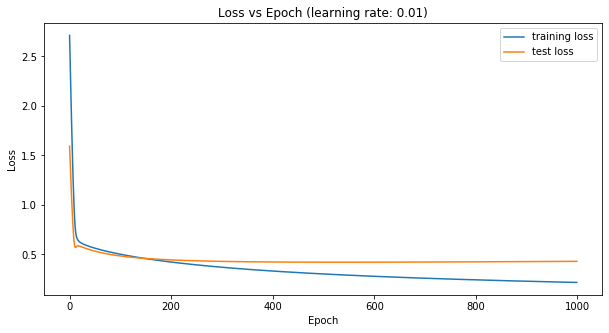

In [28]:
plt.figure(figsize=(10, 5))
plt.title('Loss vs Epoch (learning rate: 0.01)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(perceptron.losses_train)
plt.plot(perceptron.losses_test)
plt.legend(['training loss', 'test loss'])
#plt.savefig('part2_loss1.png')
plt.show()

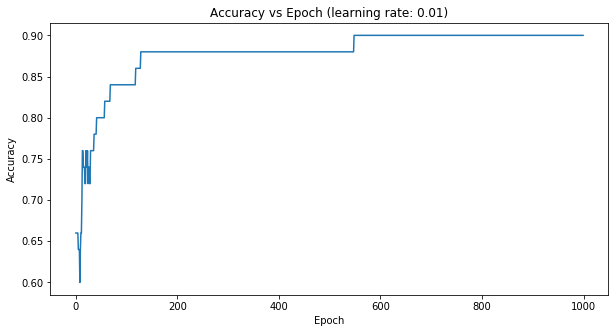

In [29]:
plt.figure(figsize=(10, 5))
plt.title('Accuracy vs Epoch (learning rate: 0.01)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(perceptron.accuracies)
#plt.savefig('part2_acc1.png')
plt.show()

In [30]:
print('Prediction accuracy (learning rate: 0.01) = %d%%' % (100 * perceptron.predict()))

Prediction accuracy (learning rate: 0.01) = 90%


Try two more learning rates:

In [31]:
perceptron2 = Perceptron(train_x_aug_flat_scaled, train_y_aug,
                         test_x_flat_scaled, test_y, eta=1e-3)

In [32]:
perceptron2.train(verbose=False)

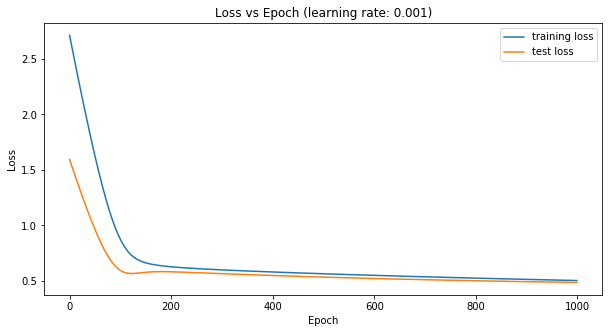

In [33]:
plt.figure(figsize=(10, 5))
plt.title('Loss vs Epoch (learning rate: 0.001)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(perceptron2.losses_train)
plt.plot(perceptron2.losses_test)
plt.legend(['training loss', 'test loss'])
#plt.savefig('part2_loss2.png')
plt.show()

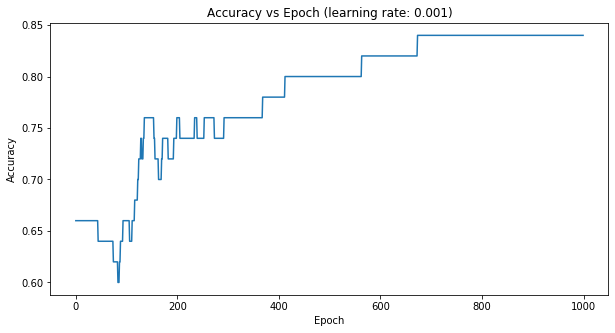

In [34]:
plt.figure(figsize=(10, 5))
plt.title('Accuracy vs Epoch (learning rate: 0.001)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(perceptron2.accuracies)
#plt.savefig('part2_acc2.png')
plt.show()

In [35]:
print('Prediction accuracy (learning rate: 0.001) = %d%%' % (100 * perceptron2.predict()))

Prediction accuracy (learning rate: 0.001) = 84%


In [36]:
perceptron3 = Perceptron(train_x_aug_flat_scaled, train_y_aug,
                          test_x_flat_scaled, test_y, eta=1e-1)

In [37]:
perceptron3.train(verbose=False)

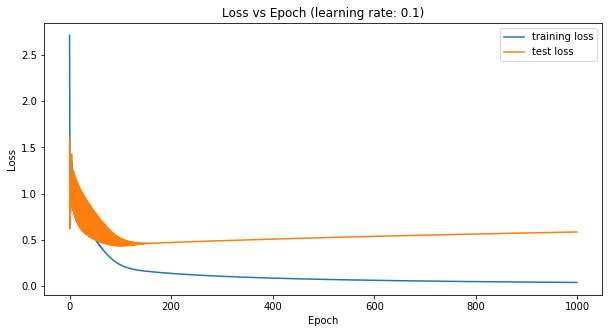

In [38]:
plt.figure(figsize=(10, 5))
plt.title('Loss vs Epoch (learning rate: 0.1)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(perceptron3.losses_train)
plt.plot(perceptron3.losses_test)
plt.legend(['training loss', 'test loss'])
#plt.savefig('part2_loss3.png')
plt.show()

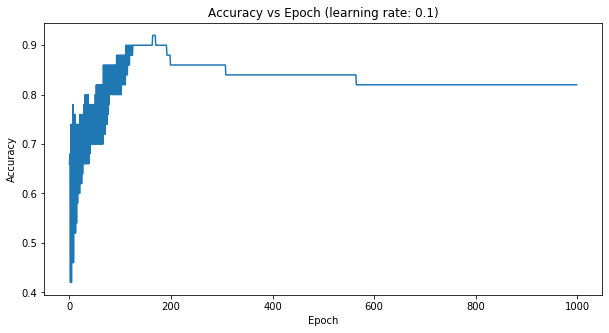

In [39]:
plt.figure(figsize=(10, 5))
plt.title('Accuracy vs Epoch (learning rate: 0.1)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(perceptron3.accuracies)
#plt.savefig('part2_acc3.png')
plt.show()

In [40]:
print('Prediction accuracy (learning rate: 0.1) = %d%%' % (100 * perceptron3.predict()))

Prediction accuracy (learning rate: 0.1) = 82%


The best classification accuracy is obtained as follows:

In [41]:
best_perceptron = Perceptron(train_x_aug_flat_scaled, train_y_aug, 
                             test_x_flat_scaled, test_y, eta=1e-1, num_iters=165)
best_perceptron.train()
print('Highest prediction accuracy (learning rate: 0.1) = %d%%' % (100 * best_perceptron.predict()))

---
Performed iteration 1:
current train loss = 2.712476
current test loss = 1.593482

---
Performed iteration 51:
current train loss = 0.506021
current test loss = 0.801738

---
Performed iteration 101:
current train loss = 0.231122
current test loss = 0.521896

---
Performed iteration 151:
current train loss = 0.162651
current test loss = 0.464655

Highest prediction accuracy (learning rate: 0.1) = 92%


# Part 3

This part is implemented in the file EfeAcer_21602217_PA2_part3_colab.ipynb, since TensorBoard produces many errors in my local machine.